In [1]:
import os
import time
import math
import json
import re 
import pandas as pd
import statsmodels.api as sm
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

palette1 = "#D0DBE7"
palette2 = "#984D64"

/Users/heart/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/heart/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
wordle_word_stats = pd.read_csv("replication-data/wordle_word_stats.csv")
participant = pd.read_csv("replication-data/participant.csv")
rdf = pd.read_csv("replication-data/rdf.csv")
gdf2 = pd.read_csv("replication-data/gdf2.csv")

# Participants

In [3]:
print("\n Native English \n")
print(participant["native_english"].value_counts(normalize=True))
print("\n Age \n")
print(participant["age"].describe())
print("\n Sex \n")
print(participant["Sex"].value_counts(normalize=True))
print("\n Wordle Play Frequency \n")
print(participant['wordle_play_frequency'].value_counts(normalize=True))


 Native English 

1    0.997018
0    0.002982
Name: native_english, dtype: float64

 Age 

count    996.000000
mean      38.113454
std       13.747551
min       18.000000
25%       27.000000
50%       35.000000
75%       47.000000
max       84.000000
Name: age, dtype: float64

 Sex 

Female    0.530815
Male      0.469185
Name: Sex, dtype: float64

 Wordle Play Frequency 

11-100    0.423459
0         0.311133
2-10      0.186879
1         0.044732
101+      0.033797
Name: wordle_play_frequency, dtype: float64


# Results

## Table 2 – DVs: Did Win, Number of Guesses, Number of Guesses (Adjusted)

In [4]:
j = rdf
j = j[j["round_index"]<=3]
columns = ["t_anger","t_empathy","anger_empathy"]
dvs = ["did_win","guess_count","guess_count_adj"] #,"end_arousal","end_valence", "did_start_bonus_rounds"]
x = []
for dv in dvs:
    res = sm.OLS(j[dv], sm.add_constant(j[columns]), M=sm.robust.norms.HuberT()).fit(
        cov_type='cluster', 
        cov_kwds={'groups': j.prolific_pid}
        )
    x.append(res)
stargazer = Stargazer(x)
stargazer.title("Prolific")
stargazer.custom_columns(['Did Win', 'Guesses',"Guesses (Adjusted)",
#                           "Arousal","Valence","Bonus Started"
                         ], [1,1,1,
                            # 1,1,1
                            ])
stargazer.covariate_order(['const','t_anger','t_empathy','anger_empathy'])
stargazer.rename_covariates({'const': 'Constant',
                             "t_anger":"Anger",
                             "t_empathy":"Empathy",
                             "anger_empathy": "Anger * Empathy"})
stargazer.significant_digits(2)
stargazer.show_degrees_of_freedom(False)
stargazer.significance_levels([0.05, 0.01, 0.001])
stargazer.show_model_numbers(False)
stargazer.add_line('Number of Participants', 3*[j.prolific_pid.nunique()])
HTML(stargazer.render_html())

/Users/heart/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/heart/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/heart/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


In [5]:
x[0].summary()
# x[1].summary()
# x[2].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                did_win   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.190
Date:                Thu, 28 Jul 2022   Prob (F-statistic):             0.0871
Time:                        15:21:52   Log-Likelihood:                -2540.7
No. Observations:                3975   AIC:                             5089.
Df Residuals:                    3971   BIC:                             5115.
Df Model:                           3                                         
Covariance Type:              cluster                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.7209      0.019     37.628      0.000       0.683       0.758
t_anger          -0.0656      0.028     -2.311      0.021      -0.121      -0.010
t_empathy        -0.0216      0.028     -0.761      0.446      -0.077       0.034
anger_empathy     0.0840      0.040      2.083      0.037       0.005       0.163
==============================================================================
Omnibus:                     6022.388   Durbin-Watson:                   1.582
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              744.820
Skew:                          -0.856   Prob(JB):                    1.84e-162
Kurtosis:                       1.750   Cond. No.                         6.77
==============================================================================

Warnings:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [6]:
rdf[rdf.round_index<=3].prolific_pid.value_counts().value_counts()

4    982
1      9
3      8
2      7
Name: prolific_pid, dtype: int64

## Round Fixed Effects

In [7]:
j = rdf
j = j[j["round_index"]<=3]
j["r1"] = (j.round_index==0).astype(int)
j["r2"] = (j.round_index==1).astype(int)
j["r3"] = (j.round_index==2).astype(int)
j["r4"] = (j.round_index==3).astype(int)
columns = ["t_anger","t_empathy","anger_empathy","r1","r2","r3","r4"]
dvs = ["did_win","guess_count","guess_count_adj",] #,"end_arousal","end_valence", "did_start_bonus_rounds"]
x = []
for dv in dvs:
    res = sm.OLS(j[dv], sm.add_constant(j[columns]), M=sm.robust.norms.HuberT()).fit(
        cov_type='cluster', 
        cov_kwds={'groups': j.prolific_pid}
        )
    x.append(res)
stargazer = Stargazer(x)
stargazer.title("Prolific")
stargazer.custom_columns(['Did Win', 'Guesses',"Guesses (Adjusted)",
                         ], [1,1,1,
                            # 1,1,1
                            ])
stargazer.covariate_order(['const','t_anger','t_empathy','anger_empathy',"r1","r2","r3","r4"])
stargazer.rename_covariates({'const': 'Constant',
                             "t_anger":"Anger",
                             "t_empathy":"Empathy",
                             "anger_empathy": "Anger * Empathy"})
stargazer.significant_digits(2)
stargazer.show_degrees_of_freedom(False)
stargazer.significance_levels([0.05, 0.01, 0.001])
stargazer.show_model_numbers(False)
stargazer.add_line('Number of Participants', 3*[j.prolific_pid.nunique()])
HTML(stargazer.render_html())

<ipython-input-7-4d214cb2085d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  j["r1"] = (j.round_index==0).astype(int)
<ipython-input-7-4d214cb2085d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  j["r2"] = (j.round_index==1).astype(int)
<ipython-input-7-4d214cb2085d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [8]:
x[0].summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                did_win   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     840.8
Date:                Thu, 28 Jul 2022   Prob (F-statistic):               0.00
Time:                        15:21:52   Log-Likelihood:                -2438.9
No. Observations:                3975   AIC:                             4892.
Df Residuals:                    3968   BIC:                             4936.
Df Model:                           6                                         
Covariance Type:              cluster                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5764      0.015     37.586      0.000       0.546       0.606
t_anger          -0.0654      0.028     -2.303      0.021      -0.121      -0.010
t_empathy        -0.0217      0.028     -0.763      0.445      -0.077       0.034
anger_empathy     0.0839      0.040      2.078      0.038       0.005       0.163
r1                0.2408      0.010     24.907      0.000       0.222       0.260
r2               -0.0029      0.012     -0.241      0.810      -0.026       0.020
r3                0.2390      0.010     24.410      0.000       0.220       0.258
r4                0.0996      0.011      8.843      0.000       0.078       0.122
==============================================================================
Omnibus:                     2003.311   Durbin-Watson:                   1.463
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              620.763
Skew:                          -0.794   Prob(JB):                    1.60e-135
Kurtosis:                       1.893   Cond. No.                     6.27e+15
==============================================================================

Warnings:
[1] Standard Errors are robust to cluster correlation (cluster)
[2] The smallest eigenvalue is 1.94e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Heterogeneity of Treatment Effects

### Cognitive Reflection Test (CRT)

In [9]:
j = rdf
j = j[j["round_index"]<=3]
columns = ["t_anger","t_empathy","anger_empathy","crt","anger_crt","empathy_crt","anger_empathy_crt"]
dvs = ["did_win","guess_count","guess_count_adj"]
x = []
for dv in dvs:
    res = sm.OLS(j[dv], sm.add_constant(j[columns]), M=sm.robust.norms.HuberT()).fit(
        cov_type='cluster', 
        cov_kwds={'groups': j.prolific_pid}
        )
    x.append(res)
stargazer = Stargazer(x)
stargazer.title("Prolific")
stargazer.custom_columns(['Did Win', 'Guesses',"Guesses (Adjusted)"], [1,1,1])
stargazer.covariate_order(['const','t_anger','t_empathy','anger_empathy',"crt","anger_crt","empathy_crt","anger_empathy_crt"])
stargazer.rename_covariates({'const': 'Constant',
                             "t_anger":"Anger",
                             "t_empathy":"Empathy",
                             "anger_empathy": "Anger * Empathy",
                            "crt": "CRT",
                            "anger_crt":"CRT * Anger",
                             "empathy_crt":"CRT * Empathy",
                             "anger_empathy_crt":"CRT * Anger * Empathy",
                            })
stargazer.significant_digits(2)
stargazer.show_degrees_of_freedom(False)
stargazer.significance_levels([0.05, 0.01, 0.001])
stargazer.show_model_numbers(False)
stargazer.add_line('Number of Participants', 3*[j.prolific_pid.nunique()])
HTML(stargazer.render_html())

/Users/heart/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/heart/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/heart/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


### Never Played Wordle

In [10]:
j = rdf
j = j[j["round_index"]<=3]
columns = ["t_anger","t_empathy","anger_empathy","wordle_0","anger_exp","empathy_exp","anger_empathy_exp"]
dvs = ["did_win","guess_count","guess_count_adj"]
x = []
for dv in dvs:
    res = sm.OLS(j[dv], sm.add_constant(j[columns]), M=sm.robust.norms.HuberT()).fit(
        cov_type='cluster', 
        cov_kwds={'groups': j.prolific_pid}
        )
    x.append(res)
stargazer = Stargazer(x)
stargazer.title("Prolific")
stargazer.custom_columns(['Did Win', 'Guesses',"Guesses (Adjusted)"], [1,1,1])
stargazer.covariate_order(['const','t_anger','t_empathy','anger_empathy',"wordle_0","anger_exp","empathy_exp","anger_empathy_exp"])
stargazer.rename_covariates({'const': 'Constant',
                             "t_anger":"Anger",
                             "t_empathy":"Empathy",
                             "anger_empathy": "Anger * Empathy",
                            "wordle_0": "Never Played Wordle",
                            "anger_exp":"Never Played Wordle * Anger",
                             "empathy_exp":"Never Played Wordle * Empathy",
                             "anger_empathy_exp": " Never Played Wordle * Anger * Empathy",})
stargazer.significant_digits(2)
stargazer.show_degrees_of_freedom(False)
stargazer.significance_levels([0.05, 0.01, 0.001])
stargazer.show_model_numbers(False)
stargazer.add_line('Number of Participants', 3*[j.prolific_pid.nunique()])
HTML(stargazer.render_html())

/Users/heart/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/heart/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/heart/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


### Sex

In [11]:
j = rdf
j = j[j["round_index"]<=3]
columns = ["t_anger","t_empathy","anger_empathy","female","anger_fem","empathy_fem","anger_empathy_fem"]
dvs = ["did_win","guess_count","guess_count_adj"] 
x = []
for dv in dvs:
    res = sm.OLS(j[dv], sm.add_constant(j[columns]), M=sm.robust.norms.HuberT()).fit(
        cov_type='cluster', 
        cov_kwds={'groups': j.prolific_pid}
        )
    x.append(res)
stargazer = Stargazer(x)
stargazer.title("Prolific")
stargazer.custom_columns(['Did Win', 'Guesses',"Guesses (Adjusted)"], [1,1,1])
stargazer.covariate_order(['const','t_anger','t_empathy','anger_empathy',"female","anger_fem","empathy_fem","anger_empathy_fem"])
stargazer.rename_covariates({'const': 'Constant',
                             "t_anger":"Anger",
                             "t_empathy":"Empathy",
                             "anger_empathy": "Anger * Empathy",
                            "female": "Female",
                            "anger_fem":"Female * Anger",
                             "empathy_fem":"Female * Empathy",
                             "anger_empathy_fem": "Female * Anger * Empathy"})
stargazer.significant_digits(2)
stargazer.show_degrees_of_freedom(False)
stargazer.significance_levels([0.1, 0.05, 0.001])
stargazer.show_model_numbers(False)
stargazer.add_line('Number of Participants', 3*[j.prolific_pid.nunique()])
HTML(stargazer.render_html())

/Users/heart/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/heart/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/heart/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


## Guess Level Entropy Reduction

/Users/heart/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/heart/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/heart/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/heart/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/heart/anaconda3/lib/python3.8/site-packages/s

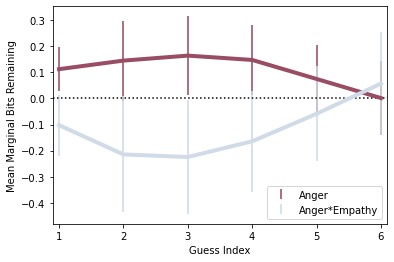

In [12]:
jj = gdf2
columns = ["t_anger","t_empathy","anger_empathy"]
dvs = ['log_guesses_mean_2k']
x = []
gi = 0
y1 = []
y2 = []
y3 = []
z1 = []
z2 = []
z3 = []
gr = []
npart = []
for t in range(0,6):
#     print(t)
    for dv in dvs:
        k = jj[(jj.round_index<=3) & (jj.guess_index==t) & (jj.was_valid==1)]
#         print(dv)
        res = sm.OLS(k[dv], sm.add_constant(k[columns]), M=sm.robust.norms.HuberT()).fit(
                cov_type='cluster', 
                cov_kwds={'groups': k.prolific_pid}
                )
        x.append(res)
    gr.append(t)
#     print(x[t].params[1])
#     print(x[t].pvalues[1])
#     print(x[t].params[3])
#     print(x[t].pvalues[3])

    y1.append(x[t].params[1])
    y2.append(x[t].bse[1]*1.96)
    z1.append(x[t].params[3])
    
    z2.append(x[t].bse[3]*1.96)
    npart.append(k.prolific_pid.nunique())
stargazer = Stargazer(x)
stargazer.title("Prolific")
stargazer.custom_columns(["1st Guess",
                          "2nd Guess",
                          "3rd Guess",
                          "4th Guess",
                          "5th Guess",
                          "6th Guess"
                         ], [1,1,1,1,1,1])
stargazer.covariate_order(['const','t_anger','t_empathy','anger_empathy',
#                            "round_index", "wordle_1","wordle_2","wordle_11","wordle_101"
                          ])
stargazer.rename_covariates({'const': 'Constant',
                             "t_anger":"Anger",
                             "t_empathy":"Empathy",
                             "anger_empathy": "Anger * Empathy"})
stargazer.significant_digits(2)
stargazer.significant_digits(4)
stargazer.show_degrees_of_freedom(False)
stargazer.significance_levels([0.05, 0.01, 0.001])
stargazer.show_model_numbers(False)
stargazer.add_line('Number of Participants', npart)
plt.plot(range(1,7), y1, color=palette2, linewidth=4)
plt.errorbar(range(1,7), y1, yerr=y2, ls='none', color=palette2, alpha=.8, label="Anger", elinewidth=2)
plt.plot(range(1,7), z1, color=palette1, linewidth=4)
plt.errorbar(range(1,7), z1, yerr=z2, ls='none', color=palette1, alpha=.8, label="Anger*Empathy", elinewidth=2)

plt.hlines(xmin=.9, xmax=6.1,y=0, ls="dotted")

plt.xlabel("Guess Index")
plt.ylabel("Mean Marginal Bits Remaining")
plt.xlim(.9,6.1)
plt.legend(loc="lower right")
plt.savefig("entropy.png", dpi=300)
HTML(stargazer.render_html())

/Users/heart/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/heart/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/heart/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/heart/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/heart/anaconda3/lib/python3.8/site-packages/s

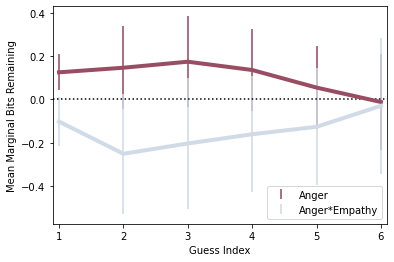

In [13]:
columns = ["t_anger","t_empathy","anger_empathy"]
dvs = ['log_guesses_median_12k']
x = []
gi = 0
y1 = []
y2 = []
y3 = []
z1 = []
z2 = []
z3 = []
gr = []
npart = []
for t in range(0,6):
#     print(t)
    for dv in dvs:
        k = jj[(jj.round_index<=3) & (jj.guess_index==t) & (jj.was_valid==1)]
#         print(dv)
        res = sm.OLS(k[dv], sm.add_constant(k[columns]), M=sm.robust.norms.HuberT()).fit(
                cov_type='cluster', 
                cov_kwds={'groups': k.prolific_pid}
                )
        x.append(res)
    gr.append(t)
    y1.append(x[t].params[1])
    y2.append(x[t].bse[1]*1.96)
    z1.append(x[t].params[3])
    z2.append(x[t].bse[3]*1.96)
    npart.append(k.prolific_pid.nunique())
#     print(x[t].params[1])
#     print(x[t].pvalues[1])
#     print(x[t].params[3])
#     print(x[t].pvalues[3])
stargazer = Stargazer(x)
stargazer.title("2")
stargazer.custom_columns(["1st Guess",
                          "2nd Guess",
                          "3rd Guess",
                          "4th Guess",
                          "5th Guess",
                          "6th Guess"
                         ], [1,1,1,1,1,1])
stargazer.covariate_order(['const','t_anger','t_empathy','anger_empathy',
#                            "round_index", "wordle_1","wordle_2","wordle_11","wordle_101"
                          ])
stargazer.rename_covariates({'const': 'Constant',
                             "t_anger":"Anger",
                             "t_empathy":"Empathy",
                             "anger_empathy": "Anger * Empathy"})
stargazer.significant_digits(2)
stargazer.significant_digits(4)
stargazer.show_degrees_of_freedom(False)
stargazer.significance_levels([0.05, 0.01, 0.001])
stargazer.show_model_numbers(False)
stargazer.add_line('Number of Participants', npart)
plt.plot(range(1,7), y1, color=palette2, linewidth=4)
plt.errorbar(range(1,7), y1, yerr=y2, ls='none', color=palette2, alpha=.8, label="Anger", elinewidth=2)
plt.plot(range(1,7), z1, color=palette1, linewidth=4)
plt.errorbar(range(1,7), z1, yerr=z2, ls='none', color=palette1, alpha=.8, label="Anger*Empathy", elinewidth=2)

plt.hlines(xmin=.9, xmax=6.1,y=0, ls="dotted")

plt.xlabel("Guess Index")
plt.ylabel("Mean Marginal Bits Remaining")
# plt.title("Entropy")
plt.xlim(.9,6.1)
plt.legend(loc="lower right")
plt.savefig("entropy12.png", dpi=300)
HTML(stargazer.render_html())



## Participant Level Self-Report Affect

In [14]:
j = participant
columns = ["t_anger","t_empathy","anger_empathy"]
dvs = ["end_arousal","end_valence"]
x = []
for dv in dvs:
    res = sm.OLS(j[dv], sm.add_constant(j[columns]), M=sm.robust.norms.HuberT()).fit(
        cov_type='cluster', 
        cov_kwds={'groups': j.prolific_pid}
        )
    x.append(res)
stargazer = Stargazer(x)
stargazer.title("Prolific")
stargazer.custom_columns(['Arousal', 'Valence'
#                           "Arousal","Valence","Bonus Started"
                         ], [1,1,
                            # 1,1,1
                            ])
stargazer.covariate_order(['const','t_anger','t_empathy','anger_empathy'])
stargazer.rename_covariates({'const': 'Constant',
                             "t_anger":"Anger",
                             "t_empathy":"Empathy",
                             "anger_empathy": "Anger * Empathy"})
stargazer.significant_digits(2)
stargazer.show_degrees_of_freedom(False)
stargazer.significance_levels([0.05, 0.01, 0.001])
stargazer.show_model_numbers(False)
stargazer.add_line('Number of Participants', 2*[j.prolific_pid.nunique()])
HTML(stargazer.render_html())

/Users/heart/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/heart/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


In [15]:
# x[1].summary()

## Extra Bonus Rounds

In [16]:
j = participant
columns = ["t_anger","t_empathy","anger_empathy"]
dvs = ["did_start_bonus_rounds"]
x = []
for dv in dvs:
    res = sm.OLS(j[dv], sm.add_constant(j[columns]), M=sm.robust.norms.HuberT()).fit(
        cov_type='cluster', 
        cov_kwds={'groups': j.prolific_pid}
        )
    x.append(res)
stargazer = Stargazer(x)
stargazer.title("Prolific")
stargazer.custom_columns(["Started Bonus Rounds",
#                           "Arousal","Valence","Bonus Started"
                         ], [1,
                            # 1,1,1
                            ])
stargazer.covariate_order(['const','t_anger','t_empathy','anger_empathy'])
stargazer.rename_covariates({'const': 'Constant',
                             "t_anger":"Anger",
                             "t_empathy":"Empathy",
                             "anger_empathy": "Anger * Empathy"})
stargazer.significant_digits(2)
stargazer.show_degrees_of_freedom(False)
stargazer.significance_levels([0.05, 0.01, 0.001])
stargazer.show_model_numbers(False)
stargazer.add_line('Number of Participants', 1*[j.prolific_pid.nunique()])
HTML(stargazer.render_html())

/Users/heart/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


## Additional Outcomes

In [17]:

j = gdf2
columns = ["t_anger","t_empathy","anger_empathy"]
dvs = ["frequency","guess_rt","positive","neutral","negative","was_valid"]
x = []
gi = 1
for dv in dvs:
    print(dv)
    if dv=="guess_rt":
        t = j[(j["guess_rt"].notnull()) & (j["round_index"]<=3)]
        res = sm.OLS(t[dv], sm.add_constant(t[columns]), M=sm.robust.norms.HuberT()).fit(
            cov_type='cluster', 
            cov_kwds={'groups': t.prolific_pid}
            )
    elif dv=="was_valid":
        i = j[(j["round_index"]<=3)]
        res = sm.OLS(i[dv], sm.add_constant(i[columns]), M=sm.robust.norms.HuberT()).fit(
            cov_type='cluster', 
            cov_kwds={'groups': i.prolific_pid}
            )
    else:
        k = j[(j.was_valid==1) & (j["round_index"]<=3)]
        res = sm.OLS(k[dv], sm.add_constant(k[columns]), M=sm.robust.norms.HuberT()).fit(
            cov_type='cluster', 
            cov_kwds={'groups': k.prolific_pid}
            )
    x.append(res)
stargazer = Stargazer(x)
stargazer.title("Prolific")
stargazer.custom_columns(["Frequency","Response Time","Positive","Neurtral","Negative","Valid",], [1,1,1,1,1,1])
stargazer.covariate_order(['const','t_anger','t_empathy','anger_empathy'])
stargazer.rename_covariates({'const': 'Contstant',
                             "t_anger":"Anger",
                             "t_empathy":"Empathy",
                             "anger_empathy": "Anger * Empathy"})
stargazer.significant_digits(2)
stargazer.significant_digits(4)
stargazer.show_degrees_of_freedom(False)
stargazer.significance_levels([0.05, 0.01, 0.001])
stargazer.show_model_numbers(False)
stargazer.add_line('Number of Participants', 6*[j.prolific_pid.nunique()])
HTML(stargazer.render_html())

/Users/heart/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/heart/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/heart/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/heart/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
/Users/heart/anaconda3/lib/python3.8/site-packages/s

frequency
guess_rt
positive
neutral
negative
was_valid


/Users/heart/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


In [18]:
print(wordle_word_stats.guess.sum())
print(wordle_word_stats.solution_w.sum())
print(gdf2[(gdf2.round_index<=3)].word.nunique())
print(gdf2[(gdf2.was_valid==1) & (gdf2.round_index<=3)].word.nunique())
print(gdf2[(gdf2.was_valid==1) & (gdf2.solution_w==1) & (gdf2.round_index<=3)].word.nunique())
print(gdf2[(gdf2.was_valid==1) & (gdf2.guess_index==0) & (gdf2.round_index<=3)].word.nunique())
print(gdf2[(gdf2.was_valid==1) & (gdf2.solution_w==1) & (gdf2.guess_index==0) & (gdf2.round_index<=3)].word.nunique())

12972.0
2315.0
6074
3175
1609
1045
727


In [19]:
print(gdf2[(gdf2.round_index<=3)].groupby("prolific_pid").was_valid.min().mean())
print((gdf2.groupby("prolific_pid").round_index.max()>=4).mean())

0.23956262425447317
0.1749502982107356
